# Homework 4 : Applied Machine Learning

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import sklearn.cluster
%matplotlib inline

In [2]:
# import data2
df = pd.read_csv('CrowdstormingDataJuly1st.csv', index_col=0)
df.head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [3]:
# drop rows for which we have no photo (and thus no skin rating)
df.dropna(subset=['rater1', 'rater2', 'weight', 'height'], inplace=True)

# group by players
group_by_players = df.groupby(level=0)

# build the data used for later analysis

# data
player_description = group_by_players.agg({'leagueCountry': lambda x: x.value_counts().index[0],
                                           'position': 'first',
                                           'height': 'mean', 
                                           'weight': 'mean',
                                           'games': 'sum',
                                           'victories': 'sum',
                                           'ties': 'sum',
                                           'defeats': 'sum',
                                           'goals': 'sum',
                                           'yellowCards': 'sum',
                                           'yellowReds': 'sum',
                                           'redCards': 'sum',
                                           'rater1': 'first',
                                           'rater2': 'first'
                                          })
player_description = pd.get_dummies(player_description, dummy_na= True, columns = ['leagueCountry', 'position'])
player_description.head()

,yellowCards,redCards,rater1,weight,ties,height,goals,games,rater2,defeats,...,position_Center Midfielder,position_Defensive Midfielder,position_Goalkeeper,position_Left Fullback,position_Left Midfielder,position_Left Winger,position_Right Fullback,position_Right Midfielder,position_Right Winger,position_nan
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,19,0,0.25,71.0,179,182.0,9,654,0.00,228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,42,1,0.00,73.0,73,183.0,62,336,0.25,122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,11,0,0.25,63.0,97,165.0,31,412,0.25,115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
aaron-ramsey,31,1,0.00,76.0,42,178.0,39,260,0.00,68,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,8,2,0.25,73.0,40,180.0,1,124,0.25,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that we still have missing values in these two fields: height and weight. We have two toptions to deal with this: either get rid of the players for which we don't have those values (in the worst case scenario, that's 24 players less) or we try to interpolate their weight and height by taking the median or the mean for example. This can introduce bias so we chose the first option

In [4]:
# labels
player_rating = player_description['rater1']

player_description.drop(['rater1', 'rater2'], axis=1, inplace=True)


## Training the classifier

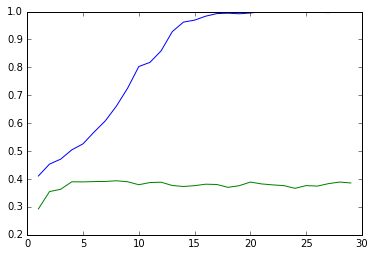

In [49]:
import warnings
warnings.filterwarnings('ignore')

X = player_description.as_matrix()
y = (player_rating*4).as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
tr_accuracy = []
te_accuracy = []
cross = []
for n in [20]:
    for d in range(1,30):
        model = RandomForestClassifier(n_estimators=n, max_depth=d)
        c = sklearn.cross_validation.cross_val_score(model, X, y, cv=20, scoring='f1_weighted')
        cross.append(np.mean(c))
        model.fit(X_train, y_train)

        te_pred = model.predict(X_test)
        tr_pred = model.predict(X_train)

        tr_error = tr_pred == y_train
        tr_error = np.sum(tr_error)/len(tr_error)

        te_error = te_pred == y_test
        te_error = np.sum(te_error)/len(te_error)

        tr_accuracy.append(tr_error)
        te_accuracy.append(te_error)
        
plt.plot(range(1,30), tr_accuracy)
plt.plot(range(1,30), cross);


### Effect of the parameters on the classifier
We see the overfitting by changing the maximum depth of the tree. See graph before

### Feature Importance

1. feature games (0.111571)
2. feature victories (0.101784)
3. feature yellowCards (0.094759)
4. feature defeats (0.092621)
5. feature goals (0.090911)
6. feature ties (0.088856)
7. feature weight (0.087823)
8. feature height (0.082417)
9. feature redCards (0.042586)
10. feature yellowReds (0.040195)
11. feature leagueCountry_Spain (0.014848)
12. feature leagueCountry_Germany (0.014545)
13. feature leagueCountry_England (0.013819)
14. feature leagueCountry_France (0.013810)
15. feature position_Center Forward (0.012262)
16. feature position_Defensive Midfielder (0.011999)
17. feature position_Center Back (0.011638)
18. feature position_nan (0.010626)
19. feature position_Attacking Midfielder (0.008998)
20. feature position_Right Fullback (0.008874)
21. feature position_Left Fullback (0.007955)
22. feature position_Left Winger (0.007649)
23. feature position_Right Winger (0.006367)
24. feature position_Right Midfielder (0.006231)
25. feature position_Left Midfielder (0.006153)
26. featu

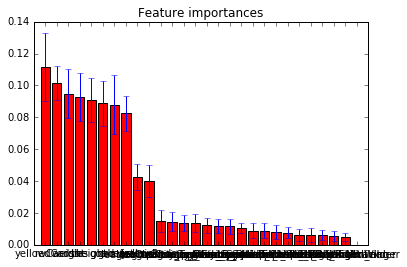

In [50]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

col = player_description.columns

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, col[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), col)
plt.xlim([-1, X.shape[1]])
plt.show()

### Unsupervised learning : Data processing

In [25]:
import warnings
warnings.filterwarnings('ignore')

df1 = df[['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']]



df1['mIAT'] = df1.apply(lambda x: x.loc['meanIAT']*x.loc['nIAT'], axis=1)
df1['sIAT'] = df1.apply(lambda x: x.loc['seIAT']*x.loc['nIAT'], axis=1)
df1['mExp'] = df1.apply(lambda x: x.loc['meanExp']*x.loc['nExp'], axis=1)
df1['sExp'] = df1.apply(lambda x: x.loc['seExp']*x.loc['nExp'], axis=1)

group_player = df1.groupby(df.index)

ref = group_player.agg({'nIAT': 'sum',
                        'mIAT': 'sum',
                        'sIAT': 'sum',
                        'nExp': 'sum',
                        'mExp': 'sum',
                        'sExp': 'sum'     
    })

ref['mIAT'] = ref['mIAT']/ref['nIAT']
ref['mExp'] = ref['mExp']/ref['nExp']

ref['sIAT'] = ref['sIAT']/ref['nExp']
ref['sExp'] = ref['sExp']/ref['nExp']

ref.drop(['nIAT', 'nExp'], axis=1, inplace=True)

df2 = df[['rater1', 'rater2']].groupby(df.index).first()

df2['skin'] = df2.apply(lambda x: (x['rater1'] + x['rater2'])/2, axis=1)

skin = df2['skin'] < 0.5





In [ ]:
import itertools
col = []
for r in range(1,5):
    col.append(list(itertools.combinations(ref.columns, r)))

sil = []
f1 = []
for i in col:
    for j in i:
        kMean = sklearn.cluster.KMeans(n_clusters=2, init='k-means++', n_init=10).fit(ref[list(j)])
        silhouette = sklearn.metrics.silhouette_score(ref[list(j)], kMean.labels_)
        f1_score = sklearn.metrics.f1_score(skin, kMean.labels_)
        print(silhouette, f1_score, j)
        sil.append(silhouette)
        f1.append(f1_score)

In [22]:
df1 = df[['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']]

ref = df1.groupby(level=0).mean()
ref.drop(['nIAT', 'nExp'], axis=1, inplace=True)

In [42]:
import itertools
col = []
for r in range(1,5):
    col.append(list(itertools.combinations(ref.columns, r)))

sil = []
f1 = []
for i in col:
    for j in i:
        kMean = sklearn.cluster.KMeans(n_clusters=2, init='k-means++', n_init=10).fit(ref[list(j)])
        silhouette = sklearn.metrics.silhouette_score(ref[list(j)], kMean.labels_)
        f1_score = sklearn.metrics.f1_score(skin, kMean.labels_)
        print(silhouette, f1_score, j)
        sil.append(silhouette)
        f1.append(f1_score)
    

0.687452528506 0.302134646962 ('sIAT',)
0.792387421116 0.240947075209 ('mIAT',)
0.683130144975 0.420616113744 ('mExp',)
0.667503155749 0.302863436123 ('sExp',)
0.792006724686 0.681034482759 ('sIAT', 'mIAT')
0.683125911237 0.611211573237 ('sIAT', 'mExp')
0.668067686809 0.302696752889 ('sIAT', 'sExp')
0.728329553027 0.675549633578 ('mIAT', 'mExp')
0.791877735244 0.240947075209 ('mIAT', 'sExp')
0.683071542424 0.420616113744 ('mExp', 'sExp')
0.728328830895 0.256374913853 ('sIAT', 'mIAT', 'mExp')
0.791855181825 0.240947075209 ('sIAT', 'mIAT', 'sExp')
0.683069009699 0.420616113744 ('sIAT', 'mExp', 'sExp')
0.728315251475 0.256374913853 ('mIAT', 'mExp', 'sExp')
0.728314571013 0.256374913853 ('sIAT', 'mIAT', 'mExp', 'sExp')


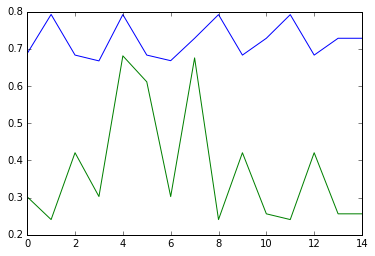

In [43]:
plt.plot(range(15), sil)
plt.plot(range(15), f1)